# `mtflib` Tutorial: Convergence and Accuracy

This notebook discusses important considerations regarding the validity and accuracy of Taylor series expansions, and visually demonstrates how accuracy improves with the order of the series.

## 1. Initialization

As always, we begin by initializing the global settings for `mtflib`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mtflib import mtf

if not mtf.get_mtf_initialized_status():
    mtf.initialize_mtf(max_order=8, max_dimension=3)
else:
    print("MTF globals are already initialized.")

x = mtf.var(1)

Initializing MTF globals with: _MAX_ORDER=8, _MAX_DIMENSION=3
Loading/Precomputing Taylor coefficients up to order 8
Global precomputed coefficients loading/generation complete.
Size of precomputed_coefficients dictionary in memory: 464 bytes, 0.45 KB, 0.00 MB
MTF globals initialized: _MAX_ORDER=8, _MAX_DIMENSION=3, _INITIALIZED=True
Max coefficient count (order=8, nvars=3): 165
Precomputed coefficients loaded and ready for use.


## 2. Important Considerations: Validity and Radius of Convergence

While `mtflib` provides tools for generating Taylor series expansions, it's crucial for the user to understand and consider the **validity and radius of convergence** of these expansions. The library automatically computes the Taylor series up to the specified `max_order`, but it does not inherently track or enforce the conditions under which these series provide a good approximation of the original function.

**User Responsibility:** It is the user's responsibility to ensure that the Taylor series expansion used is valid for the specific range of input values relevant to their application. Factors to consider include:

* **Radius of Convergence:** Taylor series for many functions only converge to the original function within a certain radius around the point of expansion (which is typically zero in our current implementation of elementary functions around a single variable). Outside this radius, the Taylor series may diverge or provide a poor approximation.
* **Point of Expansion:** The elementary functions in `mtflib` are currently implemented around an expansion point of zero for single variables. For multivariate functions, the expansion is around the origin of the variable space. The accuracy of the Taylor series is generally highest near the expansion point.
* **Form of the Equation:** The way an equation is formulated can significantly impact the convergence and the complexity of its Taylor series. For example, expanding `1/(1-x)` around `x=0` yields a simple geometric series with a radius of convergence of `|x| < 1`. However, expanding this function around `x=2` would result in a different series with a different radius of convergence.

**In summary, while `mtflib` simplifies the process of generating Taylor series, the user must exercise caution and apply their mathematical understanding to ensure the appropriateness and accuracy of the generated expansions for their intended use case.**

### Example Illustrating Radius of Convergence

Let's consider the Taylor series expansion of the function $f(x) = \frac{1}{1-x}$ around $x=0$. This function has a well-known Taylor series:

$\frac{1}{1-x} = 1 + x + x^2 + x^3 + ... = \sum_{n=0}^{\infty} x^n$

This series converges to $\frac{1}{1-x}$ only when $|x| < 1$. The radius of convergence is 1. Let's see this in practice using `mtflib` (up to the current `max_order`):

In [2]:
def manual_geometric_series(order):
    coeffs = {}
    dim = mtf.get_max_dimension()
    for i in range(order + 1):
        exponent = [0] * dim
        exponent[0] = i
        coeffs[tuple(exponent)] = 1.0
    return mtf(coeffs, dimension=dim)


geometric_series_approx = manual_geometric_series(8)
print("Taylor series approximation of 1/(1-x) around x=0:\n", geometric_series_approx)

# Let's evaluate at a point within the radius of convergence (e.g., x = 0.5)
eval_point_within = np.array([0.5, 0, 0])
result_within = geometric_series_approx.eval(eval_point_within)
exact_within = 1 / (1 - 0.5)
print(
    f"\nEvaluation at x = 0.5: Approximation = {result_within}, Exact = {exact_within}"
)

# Let's evaluate at a point outside the radius of convergence (e.g., x = 1.5)
eval_point_outside = np.array([1.5, 0, 0])
result_outside = geometric_series_approx.eval(eval_point_outside)
exact_outside = 1 / (1 - 1.5)
print(
    f"Evaluation at x = 1.5: Approximation = {result_outside}, Exact = {exact_outside}"
)

Taylor series approximation of 1/(1-x) around x=0:
          Coefficient  Order  Exponents
0 1.000000000000e+00      0  (0, 0, 0)
1 1.000000000000e+00      1  (1, 0, 0)
2 1.000000000000e+00      2  (2, 0, 0)
3 1.000000000000e+00      3  (3, 0, 0)
4 1.000000000000e+00      4  (4, 0, 0)
5 1.000000000000e+00      5  (5, 0, 0)
6 1.000000000000e+00      6  (6, 0, 0)
7 1.000000000000e+00      7  (7, 0, 0)
8 1.000000000000e+00      8  (8, 0, 0)


Evaluation at x = 0.5: Approximation = [1.99609375], Exact = 2.0
Evaluation at x = 1.5: Approximation = [74.88671875], Exact = -2.0


## 3. Accuracy vs. Order of Computation

This section visually demonstrates how the accuracy of the Taylor polynomial approximation improves as the order of the series expansion increases for a few common elementary functions. The following plots show the relationship between the order of the Taylor series (on the x-axis) and the logarithm of the accuracy (on the y-axis, represented as -log10 of the absolute error) for different elementary functions. Each subplot corresponds to a specific value of `x` (0.01, 0.1, 0.2, and 0.5). Different colored lines in each subplot represent different elementary functions, allowing for a comparison of their convergence rates as the order of the Taylor series increases. Generally, as the order increases, the absolute error decreases, leading to a larger value on the y-axis, indicating higher accuracy.

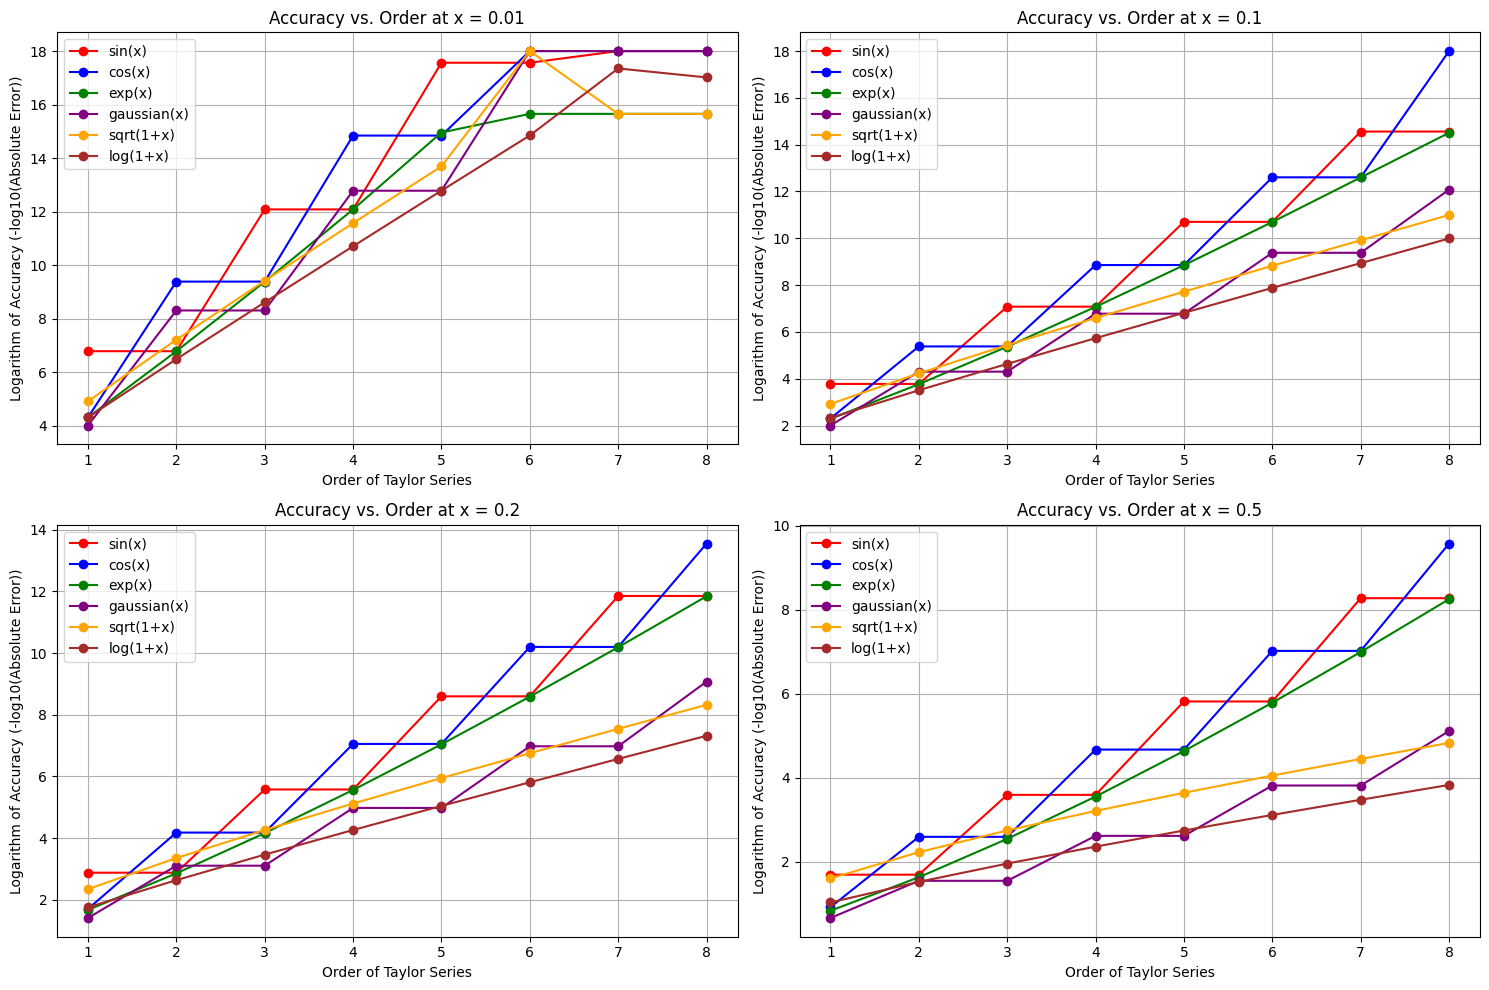

In [3]:
x_values = [0.01, 0.1, 0.2, 0.5]
num_plots = len(x_values)
num_rows = (num_plots + 1) // 2
num_cols = 2

max_order_for_plot = 8
orders = range(1, max_order_for_plot + 1)

functions = {
    "sin(x)": (np.sin, mtf.sin, "red"),
    "cos(x)": (np.cos, mtf.cos, "blue"),
    "exp(x)": (np.exp, mtf.exp, "green"),
    "gaussian(x)": (lambda x_val: np.exp(-(x_val**2)), mtf.gaussian, "purple"),
    "sqrt(1+x)": (
        lambda x_val: np.sqrt(1 + x_val),
        lambda var: mtf.sqrt(1 + var),
        "orange",
    ),
    "log(1+x)": (
        lambda x_val: np.log(1 + x_val),
        lambda var: mtf.log(1 + var),
        "brown",
    ),
}

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

original_max_order = mtf.get_max_order()

for i, x_val in enumerate(x_values):
    ax = axes[i]
    for name, (exact_func, taylor_func, color) in functions.items():
        errors = []
        for order in orders:
            mtf.set_max_order(order)
            taylor_series = taylor_func(x)
            approximation = taylor_series.eval(np.array([x_val, 0, 0]))
            exact_value = exact_func(x_val)
            absolute_error = np.abs(approximation - exact_value)
            errors.append(-np.log10(absolute_error + 1e-18))
        ax.plot(orders, errors, marker="o", linestyle="-", color=color, label=name)

    ax.set_xlabel("Order of Taylor Series")
    ax.set_ylabel("Logarithm of Accuracy (-log10(Absolute Error))")
    ax.set_title(f"Accuracy vs. Order at x = {x_val}")
    ax.grid(True)
    ax.legend()

mtf.set_max_order(original_max_order)

if num_plots < len(axes):
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()